# LangGrpah Subgraph

- Author: [Sunyoung Park (architectyou)](https://github.com/architectyou)
- Design: 
- Peer Review: 
- This is a part of [LangChain Open Tutorial](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial)

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb) [![Open in GitHub](https://img.shields.io/badge/Open%20in%20GitHub-181717?style=flat-square&logo=github&logoColor=white)](https://github.com/LangChain-OpenTutorial/LangChain-OpenTutorial/blob/main/99-TEMPLATE/00-BASE-TEMPLATE-EXAMPLE.ipynb)

## Overview

Using **SubGraphs** allows you to build complex systems containing multiple components, where these components themselves can become graphs. A common use case for **SubGraphs** is building multi-agent systems.

The main consideration when adding **SubGraphs** is how the parent graph and SubGraph communicate, specifically how they pass state to each other during graph execution.

- There are two scenarios:
1. When the parent graph and `subgraph` **share schema keys**. In this case, you can add nodes with the compiled `subgraph`.
2. When the parent graph and `subgraph` have **different schemas**. In this case, you need to add a **node function** that calls the `subgraph`.

This is useful when the parent graph and `subgraph` have different state schemas and the state needs to be transformed before and after calling the `subgraph`.

I'll show you how to add subgraphs for each scenario below.

![langgraph-subgraph](./assets/13-langgraph-subgraph.png)

### Table of Contents

- [Overview](#overview)
- [Environment Setup](#environment-setup)
- [Case 1: When Sharing Schema Keys](#case-1-when-sharing-schema-keys)
- [Case 2: When Not Sharing Schema Keys](#case-2-when-not-sharing-schema-keys)

### References

- [How to add and use subgraphs](https://langchain-ai.github.io/langgraph/how-tos/subgraph/)
- [How to visualize your graph](https://langchain-ai.github.io/langgraph/how-tos/visualization/#set-up-graph)
----

## Environment Setup

Setting up your environment is the first step. See the [Environment Setup](https://wikidocs.net/257836) guide for more details.


**[Note]**

The langchain-opentutorial is a package of easy-to-use environment setup guidance, useful functions and utilities for tutorials.
Check out the  [`langchain-opentutorial`](https://github.com/LangChain-OpenTutorial/langchain-opentutorial-pypi) for more details.

In [1]:
%%capture --no-stderr
%pip install langchain-opentutorial

In [2]:
# Install required packages
from langchain_opentutorial import package

package.install(
    [
        "langgraph",
        "langchain-opentutorial"
    ],
    verbose=False,
    upgrade=False,
)

You can set API keys in a `.env` file or set them manually.

[Note] If you’re not using the `.env` file, no worries! Just enter the keys directly in the cell below, and you’re good to go.

In [3]:
from dotenv import load_dotenv
from langchain_opentutorial import set_env

# Attempt to load environment variables from a .env file; if unsuccessful, set them manually.
if not load_dotenv():
    set_env(
        {
            "OPENAI_API_KEY": "",
            "LANGCHAIN_API_KEY": "",
            "LANGCHAIN_TRACING_V2": "true",
            "LANGCHAIN_ENDPOINT": "https://api.smith.langchain.com",
            "LANGCHAIN_PROJECT": "LangGraph Subgraph",
        }
    )

## Case 1: When Sharing Schema Keys

### Adding Nodes with Compiled SubGraphs

It's a common case where the parent graph and subgraph communicate through shared state keys.
For example, in multi-agent systems, agents typically communicate through a shared '`messages`' key.
When a **subgraph shares state keys with the parent graph**, you can add it to the graph following these steps:

1. Define and compile the `subgraph` workflow (`subgraph_builder` in the example below)
2. Pass the compiled `subgraph` to the `.add_node` method when defining the parent graph workflow

In [4]:
from langgraph.graph import START, END, StateGraph
from typing import TypedDict


# TypedDict class for defining subgraph state, including name key shared with parent graph and family_name key exclusive to subgraph
class ChildState(TypedDict):
    name: str  # State key shared with parent graph
    family_name: str


# First node of subgraph, sets initial value for family_name key
def subgraph_node_1(state: ChildState):
    return {"family_name": "Lee"}


# Second node of subgraph, combines subgraph-exclusive family_name key and shared name key to create new state
def subgraph_node_2(state: ChildState):
    # Perform update using family_name key only available within subgraph and shared state key name
    return {"name": f'{state["name"]} {state["family_name"]}'}


# Define subgraph structure and set node connection relationships
subgraph_builder = StateGraph(ChildState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()

Visualize the Graph.

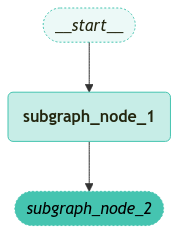

In [5]:
from langchain_opentutorial.graphs import visualize_graph

visualize_graph(subgraph, xray=True)

In [6]:
# TypedDict class for defining parent graph state, containing only the name key
class ParentState(TypedDict):
    name: str
    company: str


# First node of parent graph, modifies the name key value to create new state
def node_1(state: ParentState):
    return {"name": f'My name is {state["name"]}'}


# Define parent graph structure and set node connection relationships including subgraph
builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)
# Add compiled subgraph as a node to parent graph
builder.add_node("node_2", subgraph)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)
graph = builder.compile()

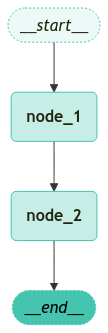

In [7]:
visualize_graph(graph, xray=True)

In [8]:
# Stream graph data chunk by chunk and print each chunk
for chunk in graph.stream({"name": "Teddy"}):
    print(chunk)

{'node_1': {'name': 'My name is Teddy'}}
{'node_2': {'name': 'My name is Teddy Lee'}}


The final output of the parent graph includes the results of the subgraph calls.

To check the output of the subgraph, you can specify `subgraphs=True` when streaming.

In [9]:
# Stream and output subgraph data chunks sequentially
# Process streaming with subgraphs by setting subgraphs=True
for chunk in graph.stream({"name": "Teddy"}, subgraphs=True):
    print(chunk)

((), {'node_1': {'name': 'My name is Teddy'}})
(('node_2:83ab5741-81c5-3032-fac4-c66046ee1e2c',), {'subgraph_node_1': {'family_name': 'Lee'}})
(('node_2:83ab5741-81c5-3032-fac4-c66046ee1e2c',), {'subgraph_node_2': {'name': 'My name is Teddy Lee'}})
((), {'node_2': {'name': 'My name is Teddy Lee'}})


## Case 2: When Not Sharing Schema Keys

### Adding Node Functions That Call Subgraphs

In more complex systems, you might need to **define subgraphs with completely different schemas from the parent graph** (cases where there are no shared state keys).

In such cases, you need to define a node function that calls the `subgraph`.

This function must transform the parent state into child state before calling the `subgraph`, and transform the results back into parent state before returning state updates from the node.

Below, we'll show how to modify the original example to call the `subgraph` within a node.


[**Note**]
- You **cannot** call more than one subgraph within the same node.

In [10]:
# Define subgraph state type (no shared keys with parent graph)
class ChildState(TypedDict):
    # Keys not shared with parent graph
    name: str


# First node of subgraph: sets initial value for name key
def subgraph_node_1(state: ChildState):
    return {"name": "Teddy " + state["name"]}


# Second node of subgraph: returns name value as is
def subgraph_node_2(state: ChildState):
    return {"name": f'My name is {state["name"]}'}


# Initialize subgraph builder and configure node connections
subgraph_builder = StateGraph(ChildState)
subgraph_builder.add_node(subgraph_node_1)
subgraph_builder.add_node(subgraph_node_2)
subgraph_builder.add_edge(START, "subgraph_node_1")
subgraph_builder.add_edge("subgraph_node_1", "subgraph_node_2")
subgraph = subgraph_builder.compile()


# Define parent graph state type
class ParentState(TypedDict):
    family_name: str
    full_name: str


# First node of parent graph: returns family_name value as is
def node_1(state: ParentState):
    return {"family_name": state["family_name"]}


# Second node of parent graph: handles state transformation with subgraph and processes results
def node_2(state: ParentState):
    # Transform parent state to subgraph state
    response = subgraph.invoke({"name": state["family_name"]})
    # Transform subgraph response back to parent state
    return {"full_name": response["name"]}


# Initialize parent graph builder and configure node connections
builder = StateGraph(ParentState)
builder.add_node("node_1", node_1)

# Use node_2 function that calls subgraph instead of compiled subgraph
builder.add_node("node_2", node_2)
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_2", END)
graph = builder.compile()

Visualize the Graph

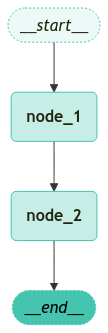

In [11]:
visualize_graph(graph, xray=True)

In [12]:
# Stream and output subgraph data chunks sequentially
# Process streaming with subgraphs by setting subgraphs=True
for chunk in graph.stream({"family_name": "Lee"}, subgraphs=True):
    print(chunk)

((), {'node_1': {'family_name': 'Lee'}})
(('node_2:64295ff5-a73e-84c0-8221-a7621d6ee521',), {'subgraph_node_1': {'name': 'Teddy Lee'}})
(('node_2:64295ff5-a73e-84c0-8221-a7621d6ee521',), {'subgraph_node_2': {'name': 'My name is Teddy Lee'}})
((), {'node_2': {'full_name': 'My name is Teddy Lee'}})
